In [ ]:
# Step 1: Install required packages
!pip install -q xgboost imbalanced-learn scikit-learn matplotlib seaborn

In [ ]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score, auc, brier_score_loss,
    jaccard_score
)
# Import calibration_curve from sklearn.calibration
from sklearn.calibration import calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [ ]:
# Step 3: Load and prepare data
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/AI ML project/creditcard_2023.csv")
df.drop(columns=['id'], inplace=True)
X = df.drop('Class', axis=1)
y = df['Class']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
# Step 4: Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [ ]:
# Step 5: Utility functions
def plot_confusion(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
def plot_roc_curve(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{title} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} - ROC Curve')
    plt.legend()
    plt.show()

In [ ]:
def plot_roc_curve(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{title} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} - ROC Curve')
    plt.legend()
    plt.show()

In [ ]:
def plot_pr_curve(y_true, y_prob, title):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.plot(recall, precision, label=title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title} - Precision-Recall Curve')
    plt.legend()
    plt.show()

In [ ]:
def plot_calibration(y_true, y_prob, title):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=title)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.title(f'{title} - Calibration Curve')
    plt.legend()
    plt.show()

In [ ]:
def plot_threshold_metrics(y_true, y_prob, title):
    thresholds = np.linspace(0.01, 0.99, 50)
    f1s, ious = [], []
    for t in thresholds:
        preds = (y_prob >= t).astype(int)
        f1s.append(f1_score(y_true, preds))
        ious.append(jaccard_score(y_true, preds))
    plt.plot(thresholds, f1s, label="F1 Score")
    plt.plot(thresholds, ious, label="IOU Score")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f'{title} - Threshold vs Score')
    plt.legend()
    plt.show()

In [ ]:
def plot_threshold_metrics(y_true, y_prob, title):
    thresholds = np.linspace(0.01, 0.99, 50)
    f1s, ious = [], []
    for t in thresholds:
        preds = (y_prob >= t).astype(int)
        f1s.append(f1_score(y_true, preds))
        ious.append(jaccard_score(y_true, preds))
    plt.plot(thresholds, f1s, label="F1 Score")
    plt.plot(thresholds, ious, label="IOU Score")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f'{title} - Threshold vs Score')
    plt.legend()
    plt.show()

In [ ]:
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='f1', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation')
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.title(f'{title} - Learning Curve')
    plt.legend()
    plt.show()

In [ ]:
# Step 6: Train and evaluate
for name, model in models.items():
    print(f"\n🚀 Training: {name}")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
    print(f"IOU Score: {jaccard_score(y_test, y_pred):.4f}")
    print(f"Brier Score Loss: {brier_score_loss(y_test, y_prob):.4f}")


🚀 Training: Logistic Regression
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     85295
           1       0.98      0.95      0.96     85294

    accuracy                           0.96    170589
   macro avg       0.97      0.96      0.96    170589
weighted avg       0.97      0.96      0.96    170589

ROC AUC: 0.9936
IOU Score: 0.9310
Brier Score Loss: 0.0259

🚀 Training: Random Forest
📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      1.00      1.00     85294

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

ROC AUC: 1.0000
IOU Score: 0.9996
Brier Score Loss: 0.0003

🚀 Training: XGBoost
📊 Classification Report:
              precision    recall  f1-score   support

           0     

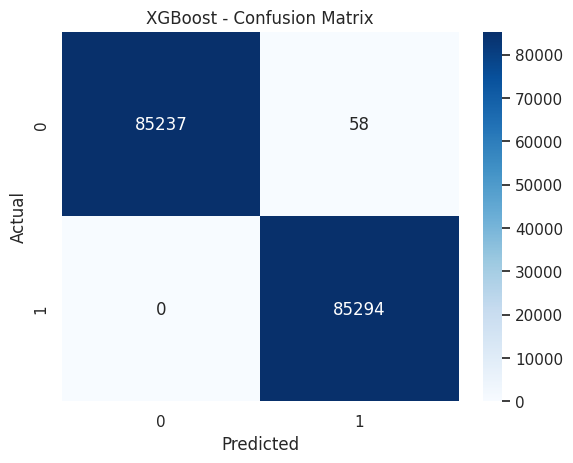

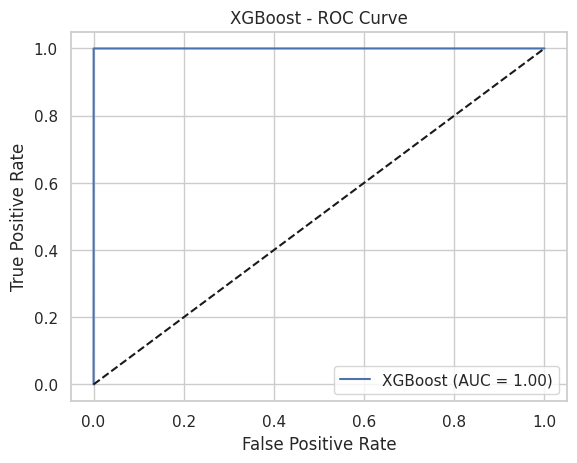

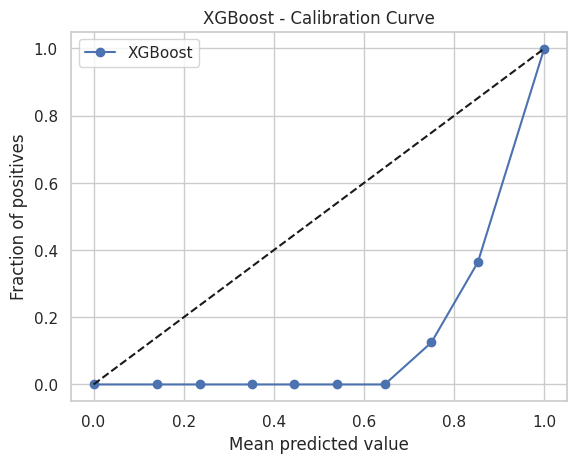

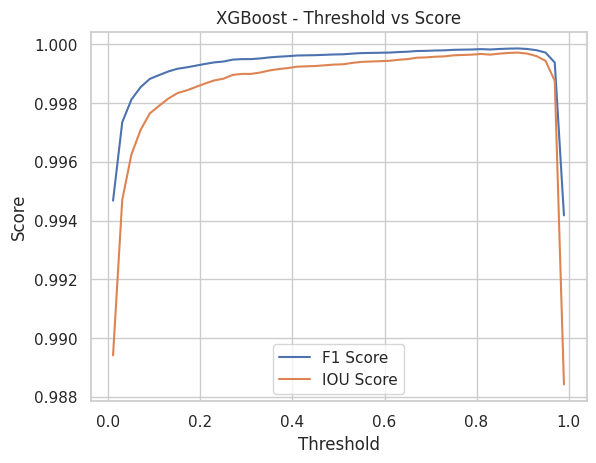

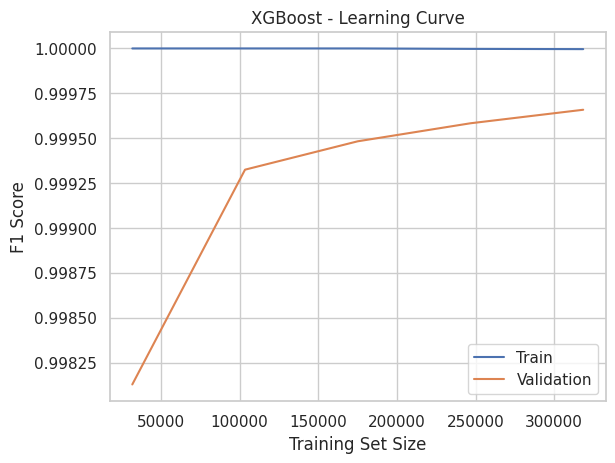

In [ ]:
    plot_confusion(confusion_matrix(y_test, y_pred), name)
    plot_roc_curve(y_test, y_prob, name)
    plot_calibration(y_test, y_prob, name)
    plot_threshold_metrics(y_test, y_prob, name)
    plot_learning_curve(model, X_train_res, y_train_res, name)